# Charting the relative performance of the gold and NIFTY 50 etfs: GOLDBEES vs. NIFTYBEES

We had previously charted gold vs. the NIFTY 50 TR index [here](https://github.com/stockviz/plutons/blob/master/gold-nifty50.ipynb). Since our gold price data-set was in USD, we had convert the prices to INR before we could compare the two. The GOLDBEES etf - an exchange traded gold etf - was launched in 2007-03-19. So if you don't care about the world before that, you can use it as a proxy for gold in INR.

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from

In [2]:
startDt <- as.Date('2007-03-20')
eqSym1 <- 'GOLDBEES'
eqSym2 <- 'NIFTYBEES'

In [3]:
eqDt1 <- equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & SYMBOL == eqSym1) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

eqDt2 <- equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & SYMBOL == eqSym2) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

eqXts1 <- xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)
eqXts2 <- xts(eqDt2$CLOSE, eqDt2$TIME_STAMP)

In [4]:
#calculate monthly returns
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(eqXts1)), 
                   Common.NormalizeMonthlyDates(monthlyReturn(eqXts2)))
names(monthlies) <-c(eqSym1, eqSym2)

#remove the first and last rows to account for stubs
monthlies <- monthlies[-1,]
monthlies <- monthlies[-nrow(monthlies),]

print(head(monthlies))

              GOLDBEES    NIFTYBEES
2007-04-20 -0.02689404  0.072778877
2007-05-20 -0.04636602  0.050219666
2007-06-20 -0.01175400  0.003050753
2007-07-20  0.01305669  0.048778802
2007-08-20  0.01403632 -0.009051563
2007-09-20  0.06266462  0.125152422


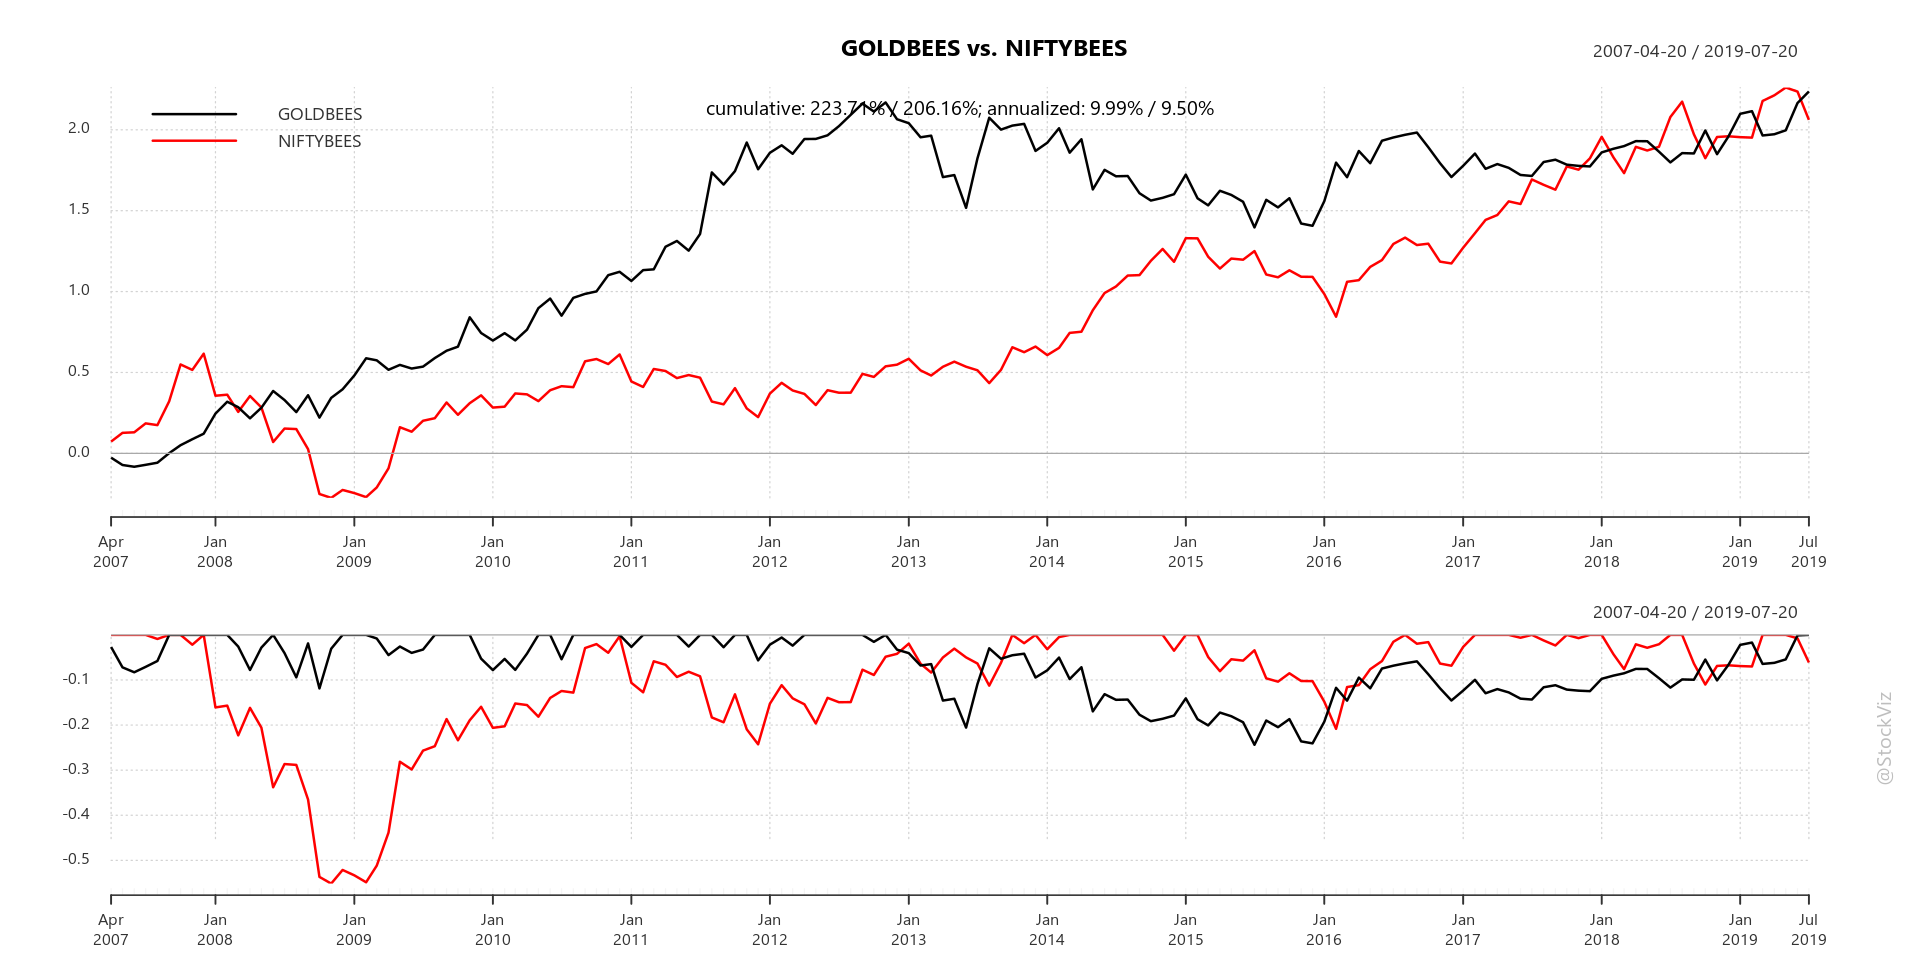

In [5]:
Common.PlotCumReturns(monthlies, sprintf("%s vs. %s", eqSym1, eqSym2), "")

In [6]:
#calculate yearly returns
yearlies <- 100*merge(yearlyReturn(eqXts1), yearlyReturn(eqXts2))
names(yearlies) <-c(eqSym1, eqSym2)

#remove the first and last rows to account for stubs
yearlies <- yearlies[-1,]
yearlies <- yearlies[-nrow(yearlies),]

print(head(yearlies))

            GOLDBEES NIFTYBEES
2008-12-31 24.457939 -52.13237
2009-12-31 24.937780  75.60081
2010-12-31 21.694852  18.60996
2011-12-30 29.869645 -24.03846
2012-12-31 11.219232  26.49080
2013-12-31 -6.393166   7.22539


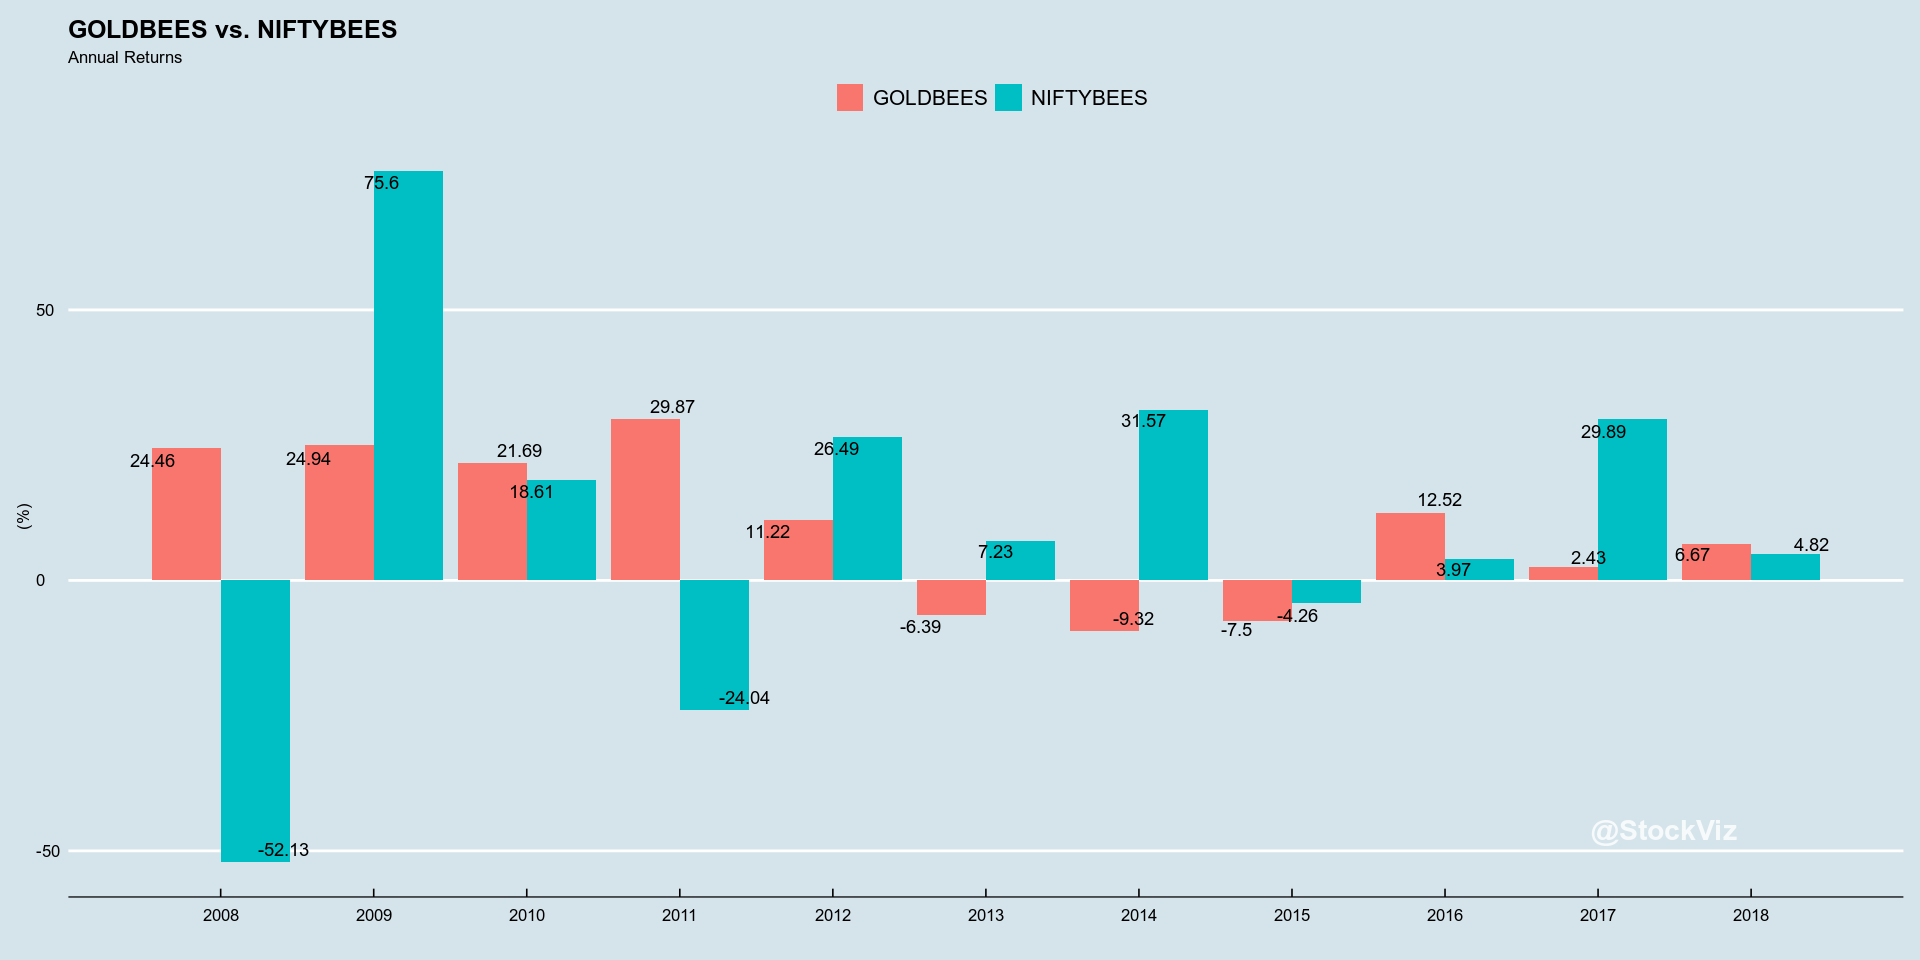

In [7]:
yDf <- data.frame(yearlies)
yDf$T <- year(index(yearlies))

toPlot <- melt(yDf, id='T')

ggplot(toPlot, aes(x=T, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=yDf$T, breaks=yDf$T) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("%s vs. %s", eqSym1, eqSym2), 
         subtitle="Annual Returns") +
    annotate("text", x=max(yDf$T), y=min(toPlot$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)